# Vector Autoregressive Models

Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web

from datetime import datetime
from statsmodels.tsa.api import VAR

In [3]:
start_date = datetime(2014, 1, 1)
end_date = datetime(2015, 1, 1)

with open('quandl.token', 'r') as file:
    quandl_token = file.read().replace('\n', '')

Pull the US Treasury bond interest rates from the FED.

In [4]:
dtb3 = web.DataReader('DTB3', 'fred', start_date, end_date).reset_index()
dtb3.columns = ['Date', 'DTB3']

dtb3.head(5)

,Date,DTB3
0,2014-01-01,NaN
1,2014-01-02,0.07
2,2014-01-03,0.07
3,2014-01-06,0.05
4,2014-01-07,0.04


Pull the returns for a single equity...in this case Microsoft.

In [5]:
msft = web.DataReader('MSFT.US', 'quandl', start_date, end_date, api_key=quandl_token).reset_index()
msft.head(5)

,Date,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
0,2014-12-31,46.73,47.44,46.45,46.45,21552450.0,0.0,1.0,43.316504,43.974640,43.056957,43.056957,21552450.0
1,2014-12-30,47.44,47.62,46.84,47.02,16384692.0,0.0,1.0,43.974640,44.141492,43.418469,43.585320,16384692.0
2,2014-12-29,47.70,47.78,47.26,47.45,14439518.0,0.0,1.0,44.215648,44.289804,43.807789,43.983910,14439518.0
3,2014-12-26,48.41,48.41,47.82,47.88,13197817.0,0.0,1.0,44.873784,44.873784,44.326882,44.382499,13197817.0
4,2014-12-24,48.64,48.64,48.08,48.14,11442790.0,0.0,1.0,45.086984,45.086984,44.567890,44.623507,11442790.0


Pull the returns for the S&P stock index as an indicator of the overall equity market.

In [6]:
spy = web.DataReader('SP500', 'fred', start_date, end_date).reset_index()
spy.columns = ['Date', 'SP500']

spy.head(5)

,Date,SP500
0,2014-01-01,NaN
1,2014-01-02,1831.98
2,2014-01-03,1831.37
3,2014-01-06,1826.77
4,2014-01-07,1837.88


Assuming there is a hidden relationship between a given stock, the equity market, and the bond market, let's build a prediction of future stock prices.

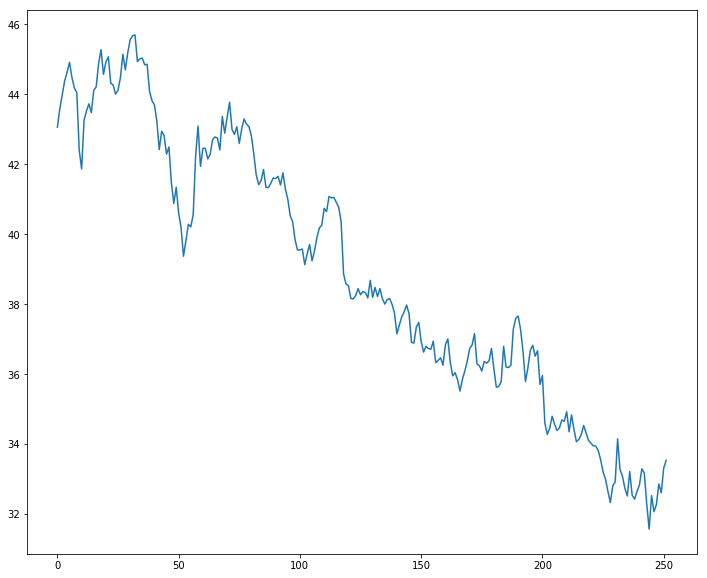

In [7]:
plt.figure(figsize=(12,10))

plt.plot(msft['AdjClose'])

In [8]:
len(msft)

252

In [9]:
len(spy)

262

In [10]:
len(dtb3)

262

Note how the length of the data frames aren't equal.  This is because the bond market is open/closed different days than the equity markets.

Convert the stock prices into a stationary series by converting to log returns.

In [11]:
msft['MSFT (return)'] = np.log(msft['AdjClose']).diff()

msft.head(5)

,Date,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume,MSFT (return)
0,2014-12-31,46.73,47.44,46.45,46.45,21552450.0,0.0,1.0,43.316504,43.974640,43.056957,43.056957,21552450.0,NaN
1,2014-12-30,47.44,47.62,46.84,47.02,16384692.0,0.0,1.0,43.974640,44.141492,43.418469,43.585320,16384692.0,0.012197
2,2014-12-29,47.70,47.78,47.26,47.45,14439518.0,0.0,1.0,44.215648,44.289804,43.807789,43.983910,14439518.0,0.009103
3,2014-12-26,48.41,48.41,47.82,47.88,13197817.0,0.0,1.0,44.873784,44.873784,44.326882,44.382499,13197817.0,0.009021
4,2014-12-24,48.64,48.64,48.08,48.14,11442790.0,0.0,1.0,45.086984,45.086984,44.567890,44.623507,11442790.0,0.005416


In [12]:
spy['SP500 (return)'] = np.log(spy['SP500']).diff()

spy.head(5)

,Date,SP500,SP500 (return)
0,2014-01-01,NaN,NaN
1,2014-01-02,1831.98,NaN
2,2014-01-03,1831.37,-0.000333
3,2014-01-06,1826.77,-0.002515
4,2014-01-07,1837.88,0.006063


Now combine the three datasets using only the dates that exist in all three.  Also, remove any NAs that are leftover.

In [13]:
merged_df = msft[['Date', 'MSFT (return)']].merge(spy[['Date', 'SP500 (return)']], on='Date', how='inner')
merged_df = merged_df.merge(dtb3, on='Date', how='inner')

merged_df.head(5)

,Date,MSFT (return),SP500 (return),DTB3
0,2014-12-31,NaN,-0.010364,0.04
1,2014-12-30,0.012197,-0.004901,0.03
2,2014-12-29,0.009103,0.000861,0.03
3,2014-12-26,0.009021,NaN,0.01
4,2014-12-24,0.005416,-0.000139,0.01


In [14]:
len(merged_df)

252

In [15]:
merged_df = merged_df.dropna()

len(merged_df)

240

So we are down to 240 common rows with no null values.

In [22]:
model = VAR(merged_df[['MSFT (return)', 'SP500 (return)', 'DTB3']])
results = model.select_order(maxlags=10)

C:\Users\Craig\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [23]:
results.summary()

,AIC,BIC,FPE,HQIC
0,-27.35,-27.30,1.329e-12,-27.33
1,-28.70,-28.53*,3.418e-13,-28.63*
2,-28.71*,-28.39,3.415e-13*,-28.58
3,-28.69,-28.24,3.483e-13,-28.51
4,-28.64,-28.06,3.630e-13,-28.41
5,-28.64,-27.92,3.649e-13,-28.35
6,-28.58,-27.73,3.882e-13,-28.23
7,-28.58,-27.59,3.892e-13,-28.18
8,-28.55,-27.43,3.996e-13,-28.10
9,-28.54,-27.28,4.051e-13,-28.03


Choose lag 2 for the model.

In [24]:
model_fitted = model.fit(2)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 09, Jan, 2020
Time:                     13:01:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -28.2763
Nobs:                     238.000    HQIC:                  -28.4592
Log likelihood:           2409.21    FPE:                3.86133e-13
AIC:                     -28.5826    Det(Omega_mle):     3.53973e-13
--------------------------------------------------------------------
Results for equation MSFT (return)
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.000461         0.001755            0.262           0.793
L1.MSFT (return)         -0.033351         0.066787           -0.499           0.618
L1.SP500 (return)        -0.974798  

Let's try a forecast.

In [25]:
lag_order = model_fitted.k_ar
lag_order

2

In [27]:
forecast_df = merged_df[['MSFT (return)', 'SP500 (return)', 'DTB3']].values[-lag_order:]
forecast_df

array([[-0.00771992, -0.00251494,  0.05      ],
       [ 0.02135897, -0.00033303,  0.07      ]])

In [28]:
predictions = model_fitted.forecast(y=forecast_df, steps=10)

In [29]:
predictions

array([[-0.00210858,  0.00255642,  0.05760281],
       [-0.00478243, -0.00086772,  0.05620576],
       [-0.00032219,  0.00049529,  0.05282811],
       [-0.00231259,  0.00037997,  0.04992977],
       [-0.00178468,  0.0003121 ,  0.04771665],
       [-0.00163817,  0.0004199 ,  0.04567866],
       [-0.00167415,  0.00041916,  0.04395583],
       [-0.00157515,  0.00044201,  0.04248   ],
       [-0.00153356,  0.00046291,  0.04120432],
       [-0.00149416,  0.00047671,  0.04011055]])